# XGBoost
- 많은 약한 결정나무(Dicision Tree)들을 부스팅(Boosting) 하는 방식으로 이어 붙여서 강력한 예측 모델을 만드는 알고리즘
    - 결정 나무
        -

In [2]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 37.4 MB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 39.6 MB/s  0:00:07m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]


In [3]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

from xgboost import XGBClassifier


In [5]:
# stroke 데이터 불러오기
df = pd.read_csv("stroke.csv")

# 타깃 변수
target = "stroke"

# id 제거
drop_cols = [target]
if "id" in df.columns:
    drop_cols.append("id")

X = df.drop(columns=drop_cols)
y = df[target]

# 숫자형 / 범주형 변수 구분
num_cols = ["age", "avg_glucose_level", "bmi"]
cat_cols = [c for c in X.columns if c not in num_cols]


In [6]:
# - 숫자형: RobustScaler (이상치 영향 ↓)
# - 범주형: OneHotEncoder (범주형 → 0/1)
preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [8]:
# 🔹 전처리 먼저 적용 (fit_transform)
X_train_preprocessed = preprocess.fit_transform(X_train)
X_test_preprocessed = preprocess.transform(X_test)

# 🔹 SMOTE 적용 (stroke=1 오버샘플링)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_preprocessed, y_train)


/home/kdt_43/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [9]:
# 기본 성능 + 과적합 방지 위한 적당한 설정
xgb_clf = XGBClassifier(
    n_estimators=300,        # 트리 개수
    max_depth=4,             # 트리 깊이
    learning_rate=0.05,      # 학습률
    subsample=0.8,           # 샘플 비율
    colsample_bytree=0.8,    # Feature 샘플 비율
    eval_metric="logloss",   # XGBoost 기본 필요 설정
    random_state=42,
    n_jobs=-1
)

# 학습
xgb_clf.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [15]:
y_pred = xgb_clf.predict(X_test_preprocessed)
y_proba = xgb_clf.predict_proba(X_test_preprocessed)[:, 1]

print("✅ XGBoost 성능 (전체 데이터)")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("-" * 60)


✅ XGBoost 성능 (전체 데이터)
              precision    recall  f1-score   support

           0      0.961     0.945     0.953       972
           1      0.197     0.260     0.224        50

    accuracy                          0.912      1022
   macro avg      0.579     0.603     0.589      1022
weighted avg      0.924     0.912     0.918      1022

ROC-AUC: 0.7928806584362139
------------------------------------------------------------


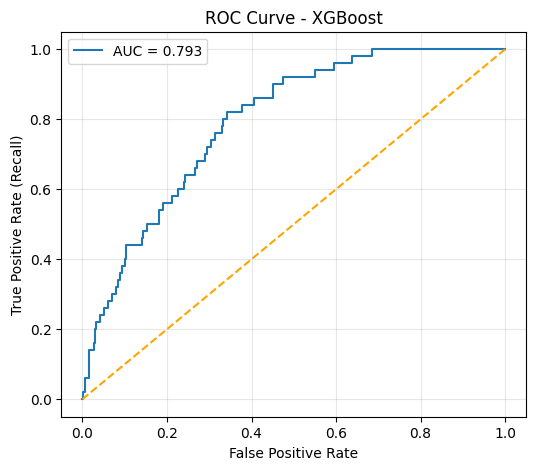

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],"--", color="orange")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [27]:
def find_best_threshold(target_recall, y_test, y_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    idx = np.argmin(np.abs(tpr - target_recall))  # tpr이 목표 recall과 가장 가까운 지점
    best_thr = thresholds[idx]
    return best_thr, fpr[idx], tpr[idx]

# 예: 목표 recall=0.90
thr, fpr_thr, recall_thr = find_best_threshold(0.90, y_test, y_proba)

print("🎯 목표 recall=0.90에 가장 가까운 threshold =", round(thr, 3))
print(" - FPR =", round(fpr_thr, 3))
print(" - recall(TPR) =", round(recall_thr, 3))

# 해당 threshold에서 stroke=1 성능 보기
y_pred_thr = (y_proba >= thr).astype(int)

print("\n🎯 선택한 threshold에서 stroke=1 성능")
print("precision_1 =", 
      round(classification_report(y_test, y_pred_thr, output_dict=True)["1"]["precision"], 3))
print("recall_1 =", 
      round(classification_report(y_test, y_pred_thr, output_dict=True)["1"]["recall"], 3))
print("f1_1 =", 
      round(classification_report(y_test, y_pred_thr, output_dict=True)["1"]["f1-score"], 3))


🎯 목표 recall=0.90에 가장 가까운 threshold = 0.025
 - FPR = 0.451
 - recall(TPR) = 0.9

🎯 선택한 threshold에서 stroke=1 성능
precision_1 = 0.093
recall_1 = 0.9
f1_1 = 0.169


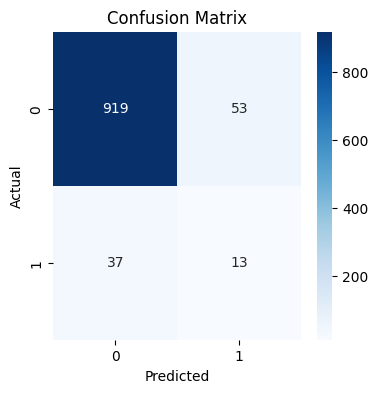

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_test : 실제 값
# y_pred : 모델이 0/1로 예측한 값 (threshold 적용된 결과)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")   # 예측 값
plt.ylabel("Actual")      # 실제 값
plt.title("Confusion Matrix")
plt.show()


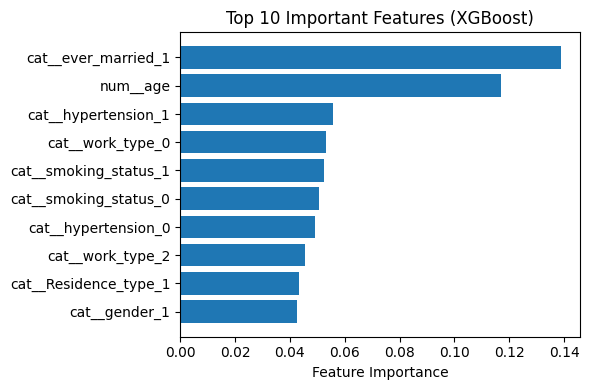

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# ✅ 전처리된 feature 이름 가져오기
#   - preprocess: ColumnTransformer (이미 fit 되어 있어야 함)
feature_names = preprocess.get_feature_names_out()

# ✅ XGBoost / RandomForest 같은 트리 기반 모델의 feature_importances_ 사용
importances = xgb_clf.feature_importances_

# 중요도 상위 10개 뽑기
idx = np.argsort(importances)[::-1][:10]
top_importances = importances[idx]
top_features = feature_names[idx]

plt.figure(figsize=(6, 4))
plt.barh(top_features, top_importances)
plt.gca().invert_yaxis()  # 위에서부터 큰 값이 보이도록 뒤집기
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (XGBoost)")
plt.tight_layout()
plt.show()


/home/kdt_43/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/kdt_43/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/kdt_43/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/kdt_43/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kdt_43/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kdt_43/miniconda3/lib/python3.9/site-pa

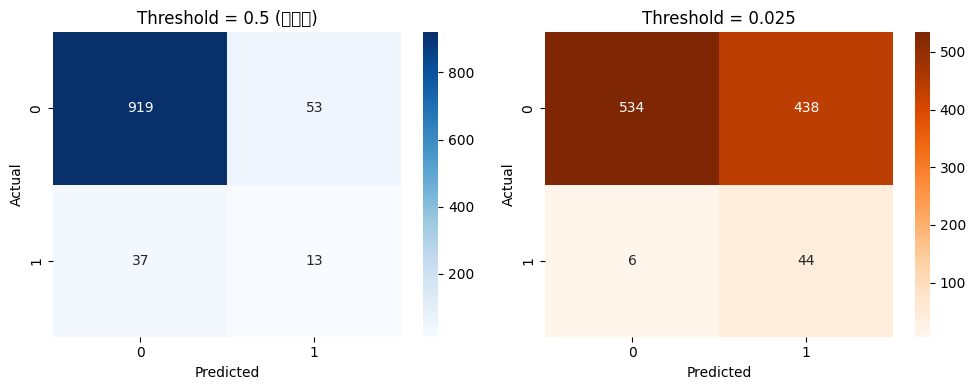

📌 기본 threshold(0.5) confusion matrix
[[919  53]
 [ 37  13]]

📌 새로운 threshold( 0.025 ) confusion matrix
[[534 438]
 [  6  44]]


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_test : 실제 정답 (0/1)
# y_proba : 모델이 예측한 stroke=1 확률

# -------------------------------
# ① threshold 적용 함수
# -------------------------------
def apply_threshold(y_proba, thr):
    # 확률이 thr 이상이면 1(stroke), 아니면 0
    return (y_proba >= thr).astype(int)

# -------------------------------
# ② 두 가지 threshold 비교 시각화
# -------------------------------
def compare_confusion_matrices(y_test, y_proba, thr_new=0.3):

    # 기존 threshold=0.5 결과
    y_pred_default = apply_threshold(y_proba, 0.5)
    cm_default = confusion_matrix(y_test, y_pred_default)

    # 새로운 threshold 결과
    y_pred_new = apply_threshold(y_proba, thr_new)
    cm_new = confusion_matrix(y_test, y_pred_new)

    # -------------------------------
    # 시각화: 2개의 행렬을 나란히 보여주기
    # -------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # 왼쪽 - default(0.5)
    sns.heatmap(cm_default, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("Threshold = 0.5 (기본값)")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # 오른쪽 - new threshold
    sns.heatmap(cm_new, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
    axes[1].set_title(f"Threshold = {thr_new}")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

    # -------------------------------
    # 간단한 요약 출력
    # -------------------------------
    print("📌 기본 threshold(0.5) confusion matrix")
    print(cm_default)
    print("\n📌 새로운 threshold(", thr_new, ") confusion matrix")
    print(cm_new)


compare_confusion_matrices(y_test, y_proba, thr_new=0.025)
